<a href="https://colab.research.google.com/github/rizkyarif12/Machine_Learning/blob/main/RNN/rizkyarifiansyah_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1: RNN untuk Analisis Sentimen

## Setup

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()
import matplotlib.pyplot as plt


In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


## Setup Input Pipeline dan Buat Teks Encoder

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'If you\'re a fan of the late Gram Parsons then this movie is definitely going to divide you! Part comedy, part road movie, but mostly a bad fictionalization of one of rock history\'s oddest tales.<br /><br />SPOILERS-- <br /><br />Basically the story concerns a well-known roadie named Phil Kaufman (played by Johnny Knoxville) who "supposedly" made a pact with cult rock/country/folk music hero Gram Parsons that stated when one of them died first (it didn\'t matter which one it was) that the other living one was to take the deceased out to the desert, Joshua Tree National Park in California to be exact, and set the body ablaze...so as to free the spirit and become one with the earth, and so on! Sure to keep his word the barely sober Kaufman, with the assistance of a self-hating, pot-headed buddy, jacks the body of the late Parsons -whom had fatally overdosed from a drug and booze bender a day prior- from the airport. And shortly after that what ensues is a cringe-worthy combin

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 45, 320,   4, ...,   0,   0,   0],
       [  2,   1,   7, ...,   0,   0,   0],
       [ 42,   1,   6, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'If you\'re a fan of the late Gram Parsons then this movie is definitely going to divide you! Part comedy, part road movie, but mostly a bad fictionalization of one of rock history\'s oddest tales.<br /><br />SPOILERS-- <br /><br />Basically the story concerns a well-known roadie named Phil Kaufman (played by Johnny Knoxville) who "supposedly" made a pact with cult rock/country/folk music hero Gram Parsons that stated when one of them died first (it didn\'t matter which one it was) that the other living one was to take the deceased out to the desert, Joshua Tree National Park in California to be exact, and set the body ablaze...so as to free the spirit and become one with the earth, and so on! Sure to keep his word the barely sober Kaufman, with the assistance of a self-hating, pot-headed buddy, jacks the body of the late Parsons -whom had fatally overdosed from a drug and booze bender a day prior- from the airport. And shortly after that what ensues is a cringe-worthy comb

## Buat Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0.00408653]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
[0.00408653]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 72ms/step - accuracy: 0.5137 - loss: 0.6822 - val_accuracy: 0.7807 - val_loss: 0.4955
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 63ms/step - accuracy: 0.7965 - loss: 0.4298 - val_accuracy: 0.8448 - val_loss: 0.3372
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.8461 - loss: 0.3476 - val_accuracy: 0.8672 - val_loss: 0.3065
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 62ms/step - accuracy: 0.8534 - loss: 0.3273 - val_accuracy: 0.8583 - val_loss: 0.3437
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8592 - loss: 0.3192 - val_accuracy: 0.8609 - val_loss: 0.3278
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.8677 - loss: 0.3111 - val_accuracy: 0.8531 - val_loss: 0.3231
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 62ms/step - accuracy: 0.8653 - loss: 0.3074 - val_accuracy: 0.8568 - val_loss: 0.3108
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.8631 - loss: 0.3090 - 

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.8540 - loss: 0.3148
Test Loss: 0.31446000933647156
Test Accuracy: 0.8527200222015381


(0.0, 0.6587148502469062)

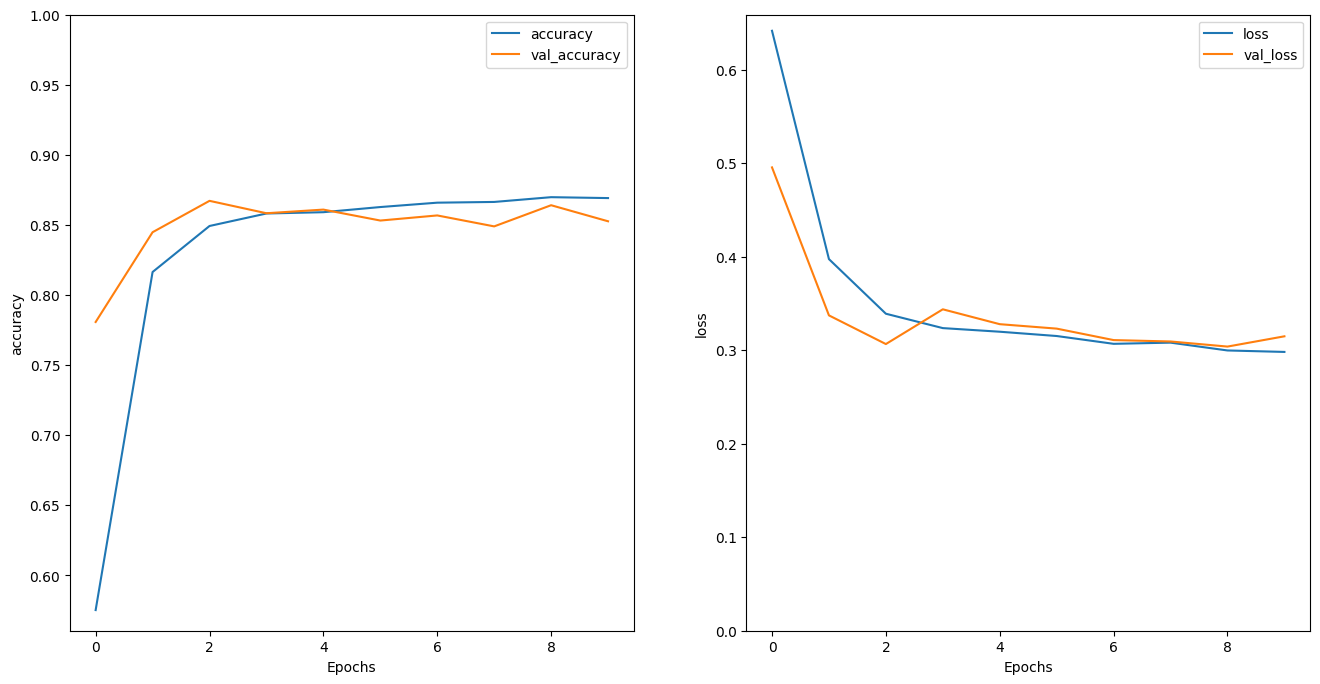

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

## Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 53s 123ms/step - accuracy: 0.5123 - loss: 0.6875 - val_accuracy: 0.6849 - val_loss: 0.5980
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.7526 - loss: 0.4978 - val_accuracy: 0.8479 - val_loss: 0.3491
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - accuracy: 0.8400 - loss: 0.3625 - val_accuracy: 0.8339 - val_loss: 0.3348
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.8531 - loss: 0.3354 - val_accuracy: 0.8536 - val_loss: 0.3434
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - accuracy: 0.8606 - loss: 0.3272 - val_accuracy: 0.8531 - val_loss: 0.3126
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 111ms/step - accuracy: 0.8659 - loss: 0.3074 - val_accuracy: 0.8646 - val_loss: 0.3275
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 88s 127ms/step - accuracy: 0.8660 - loss: 0.3126 - val_accuracy: 0.8562 - val_loss: 0.3029
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 77s 113ms/step - accuracy: 0.8662 - loss: 0

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.8655 - loss: 0.3256
Test Loss: 0.3240445554256439
Test Accuracy: 0.864359974861145


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
[[-1.822952]]


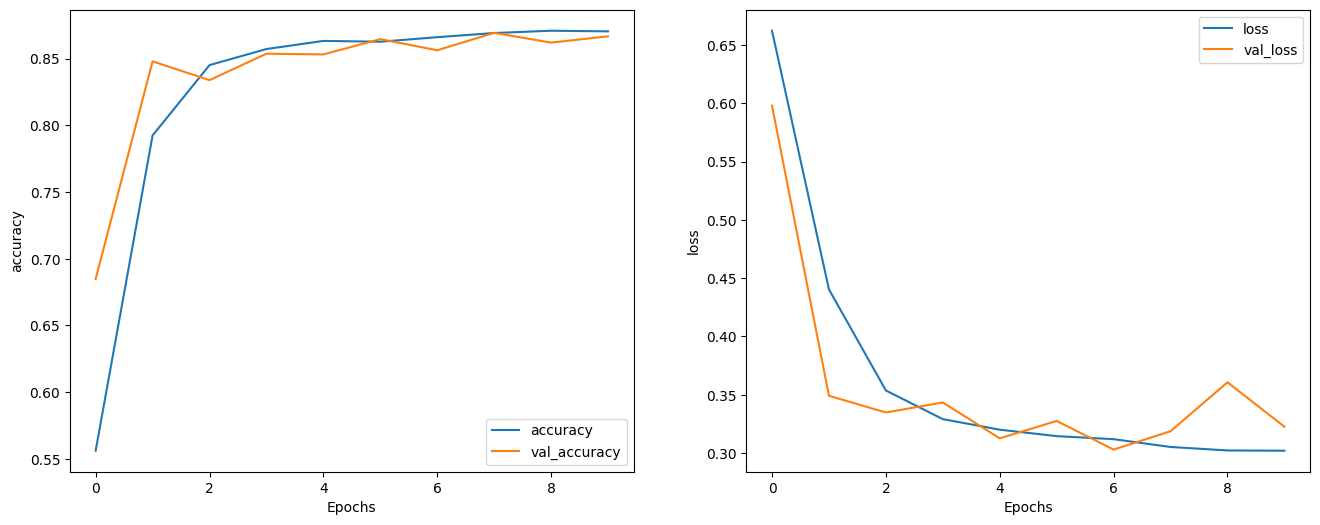

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2: Generator Teks dengan RNN

## Setup

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


## Olah Teks

### Vetorize Teks

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Memuat Training Set dan Target

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


### Membuat Batch Training

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

## Buat Model

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super(MyModel, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = self.embedding(inputs)
        if states is None:
            states = self.gru.get_initial_state(batch_size=tf.shape(inputs)[0])
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x)

        if return_state:
            return x, states
        else:
            return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

## Uji Model

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

ValueError: Exception encountered when calling MyModel.call().

[1mtoo many values to unpack (expected 2)[0m

Arguments received by MyModel.call():
  • inputs=tf.Tensor(shape=(64, 100), dtype=int64)
  • states=None
  • return_state=False
  • training=False